In [1]:
%load_ext autoreload
%autoreload 1
%aimport models

from models import *

(Re)loading load_data
(Re)loading models


In [2]:
trials = behavior[~behavior.excluded & behavior.session.isin(['experiment', 'visual'])]
pupils = samples.merge(trials, left_on=['subjectId', 'session', 'Trial'], right_on=['subjectId', 'session', 'trialCount'])
corrPupils = baselineCorrect(pupils)

In [3]:
fields = ['subjectId', 'session', 'condType', 'trialCount']
pp = pd.DataFrame()
for field, startTime, endTime in [('earlyPupil', '1s', '2s'), ('latePupil', '3s', '4s')]:
    response = corrPupils[corrPupils.offsetFromStim.between(pd.to_timedelta(startTime), pd.to_timedelta(endTime))]
    pp[field] = response.groupby(fields).Pupil.mean().groupby(fields[:-1]).mean()

pp.reset_index(inplace=True)
pp['entropy'] = pp.condType.apply(lambda c: 0. if c == 'hint' else 1. if c == 'blush' else 0.72)
pp['kld'] = pp.condType.apply(lambda c: 0. if c == 'normal' else 1.2 if c == 'wink' else 0.32)

In [4]:
excSubjects = getExcSubjects()
pp['excSubject'] = pp.subjectId.isin(excSubjects)

Subjects not selecting the preferred option in more than half of both normal and wink trials:
	 [4006, 5008, 5015, 5033, 5034, 5038, 5041, 5047, 8001, 8006, 8016, 8020, 8021, 8025]


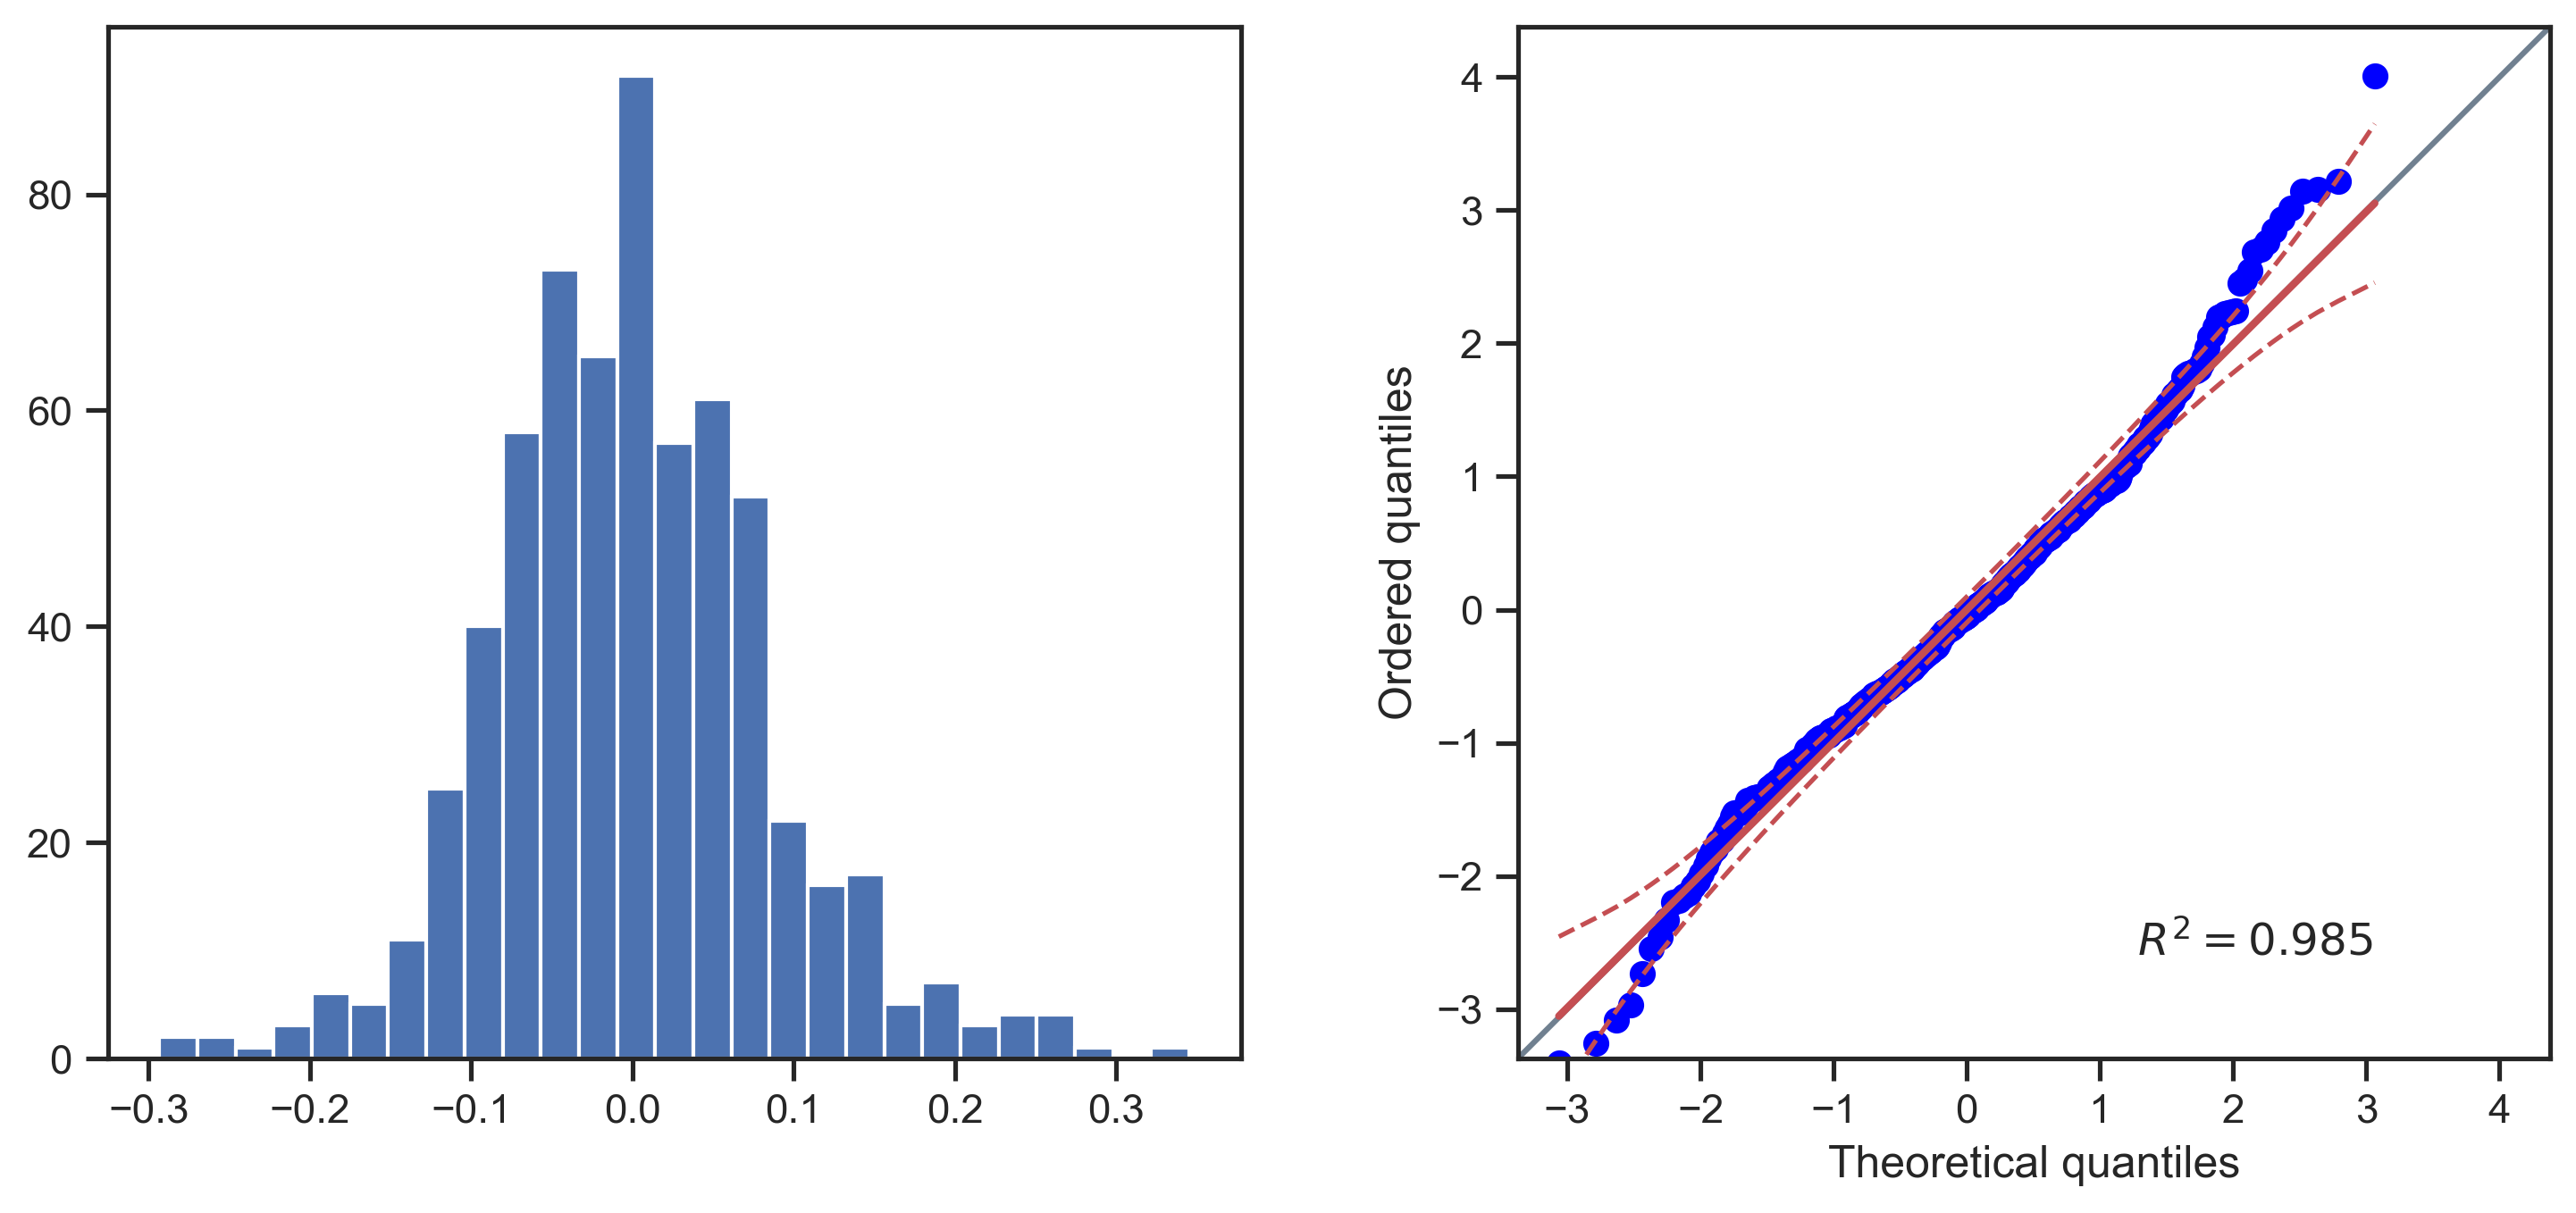

In [5]:
checkResiduals(smf.mixedlm('earlyPupil ~ C(session) + C(condType) + C(session)*C(condType)', pp, groups='subjectId'))

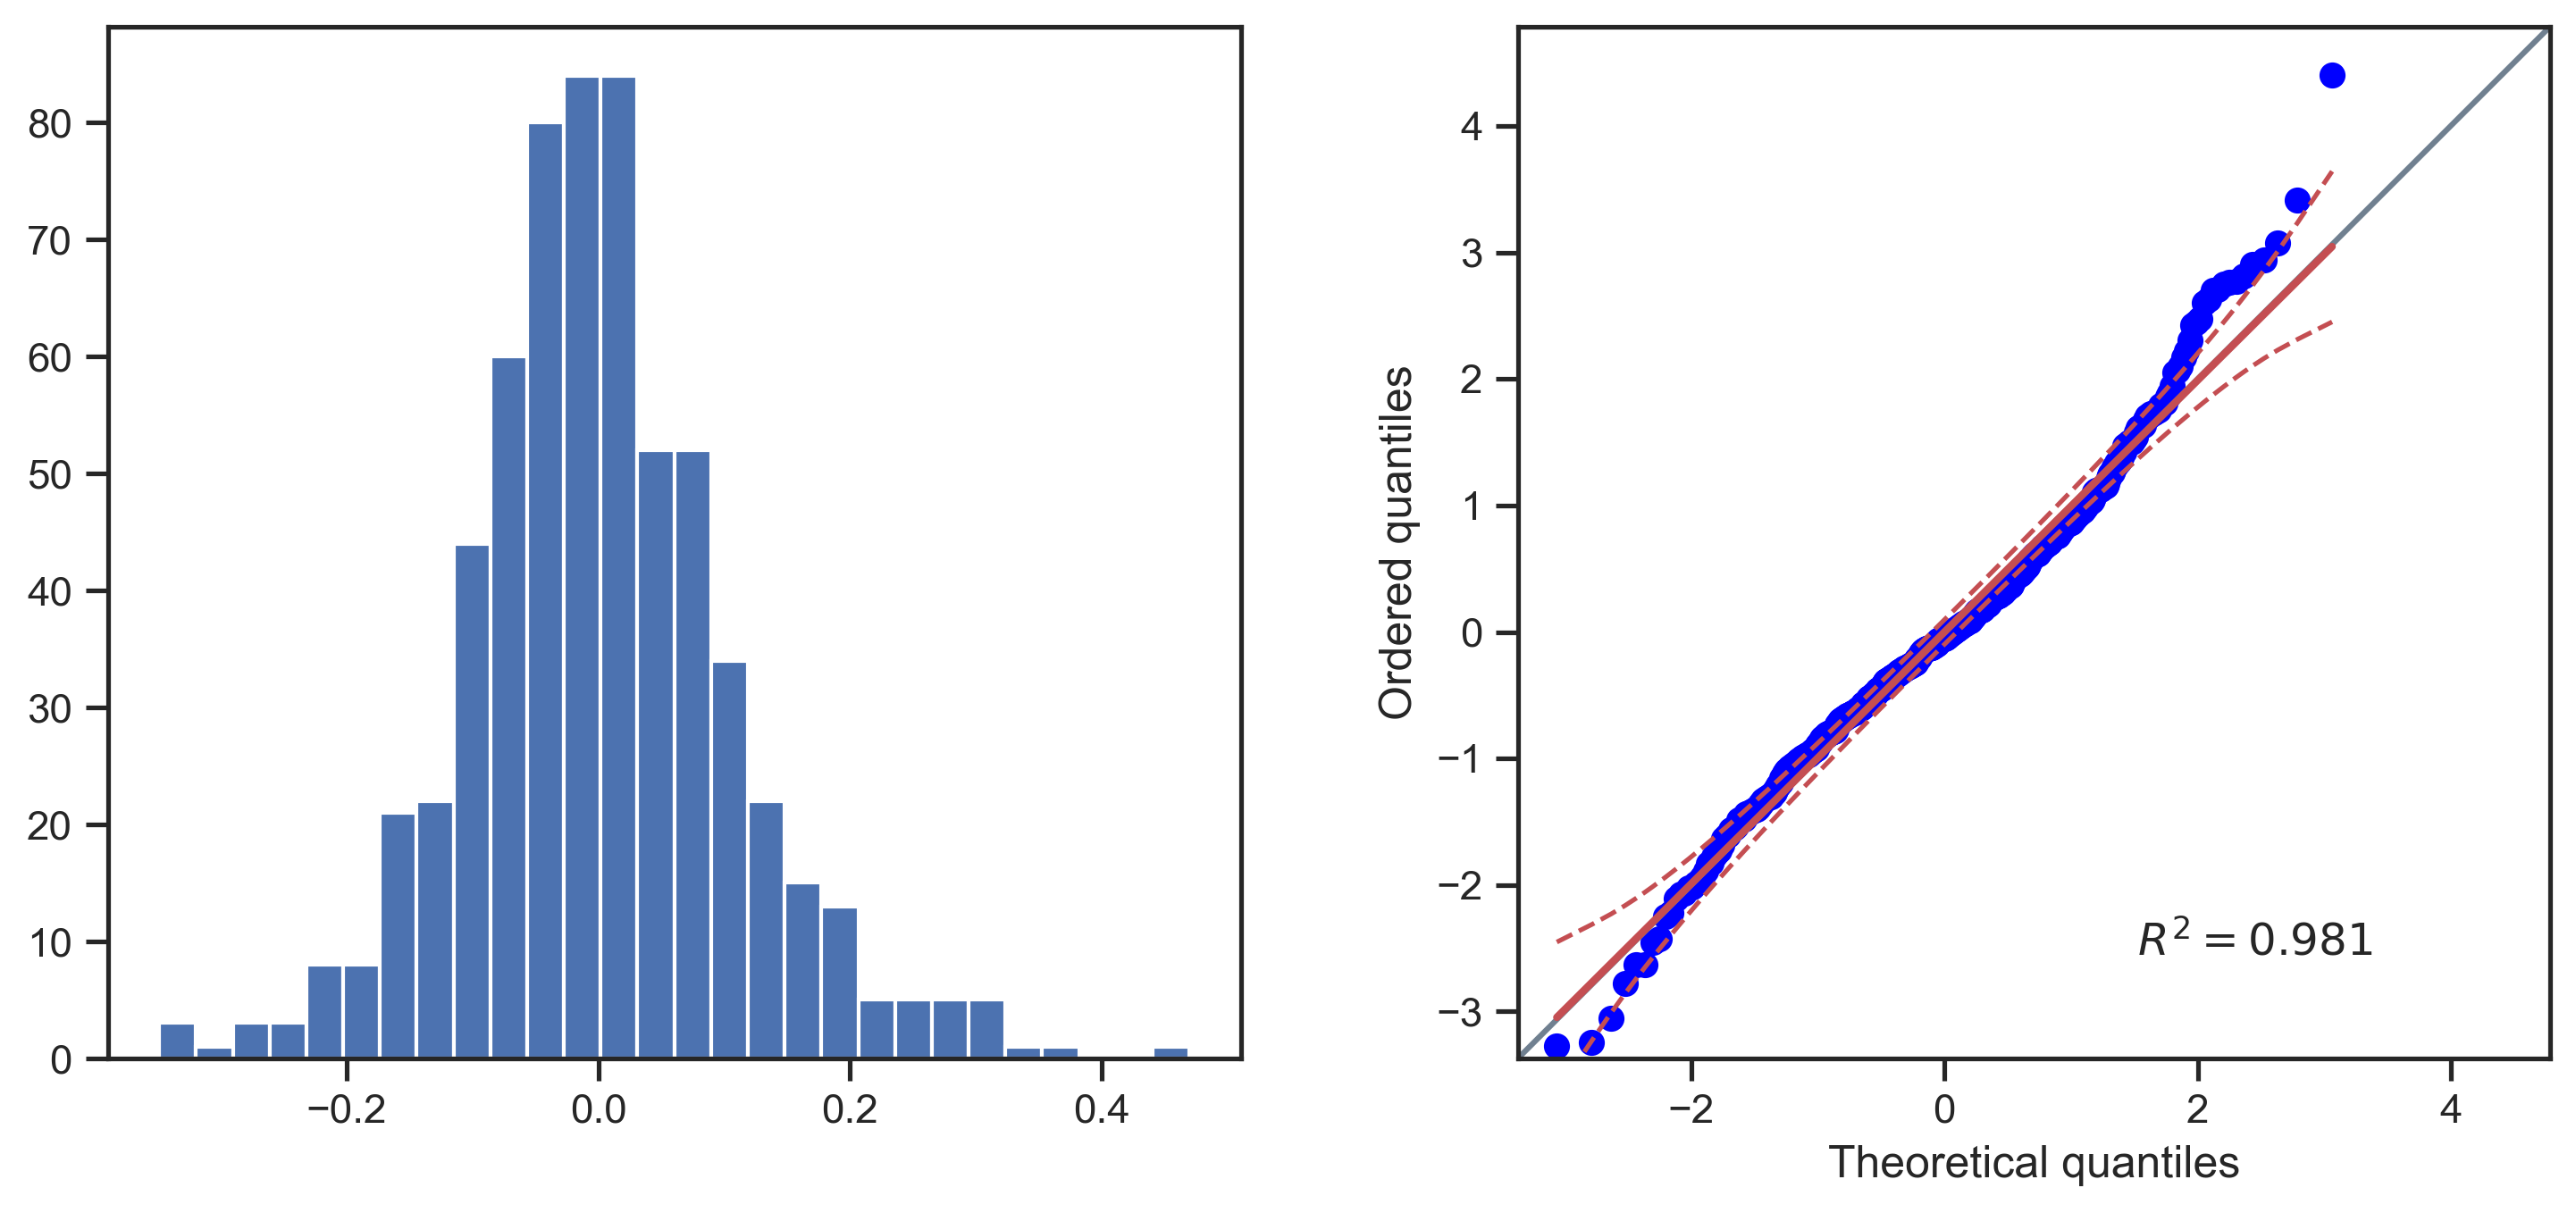

In [6]:
checkResiduals(smf.mixedlm('latePupil ~ C(session) + C(condType) + C(session)*C(condType)', pp, groups='subjectId'))

In [7]:
import seaborn as sns
import matplotlib.ticker as ticker

def condInteraction(data, conds, field, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(6, 5), dpi=100).subplots()
    ax.set_xlabel('Condition')
    ax.set_ylabel('Pupil size change [mm]')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    df = data.query("condType.isin(@conds)")
    sessionPal = sns.color_palette(['0.2', '0.8'])
    sns.pointplot(df.query("session!='interaction'"), x='condType', y=field, errorbar=None, order=conds, hue='session', palette=sessionPal, ax=ax)
    condPal = sns.color_palette([condColors[c] for c in conds])
    sns.pointplot(df.query("session.str.endswith('experiment')"), x='condType', y=field, errorbar='se', order=conds, hue='condType', palette=condPal, ax=ax)
    sns.pointplot(df.query("session.str.endswith('visual')"), x='condType', y=field, errorbar='se', order=conds, hue='condType', palette=condPal, ax=ax)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.05))
    ax.yaxis.set_tick_params(rotation=90)
    ax.legend(['experiment', 'visual control'], title=None, loc=('lower right' if field.startswith('early') else 'upper left'))

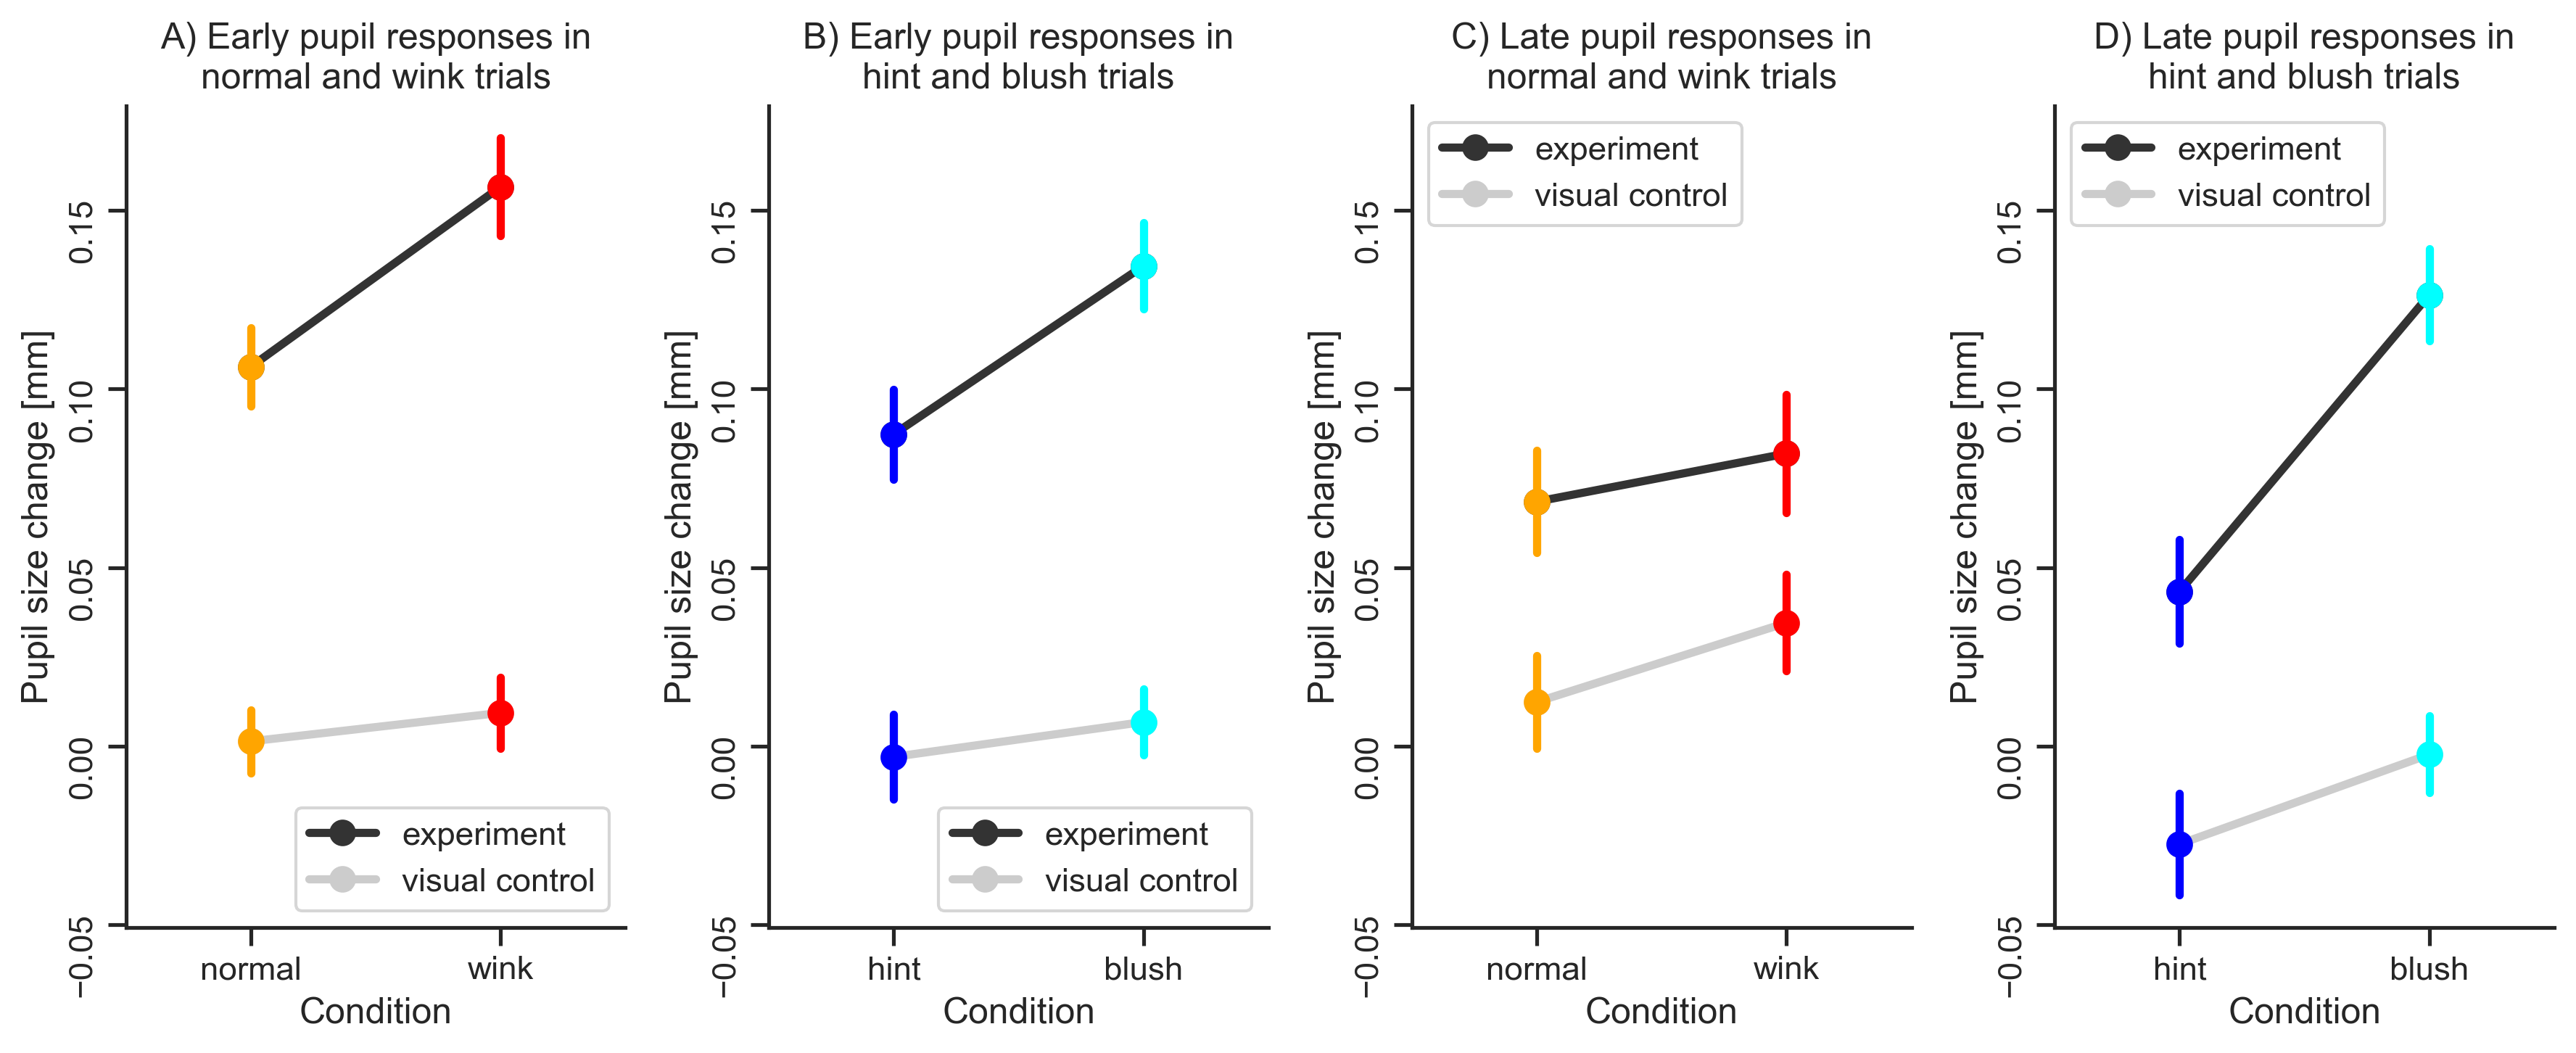

In [8]:
fig = plt.figure(figsize=(12, 5), dpi=300)
ax1, ax2, ax3, ax4 = fig.subplots(nrows=1, ncols=4)

condInteraction(pp.query('~excSubject'), ['normal', 'wink'], 'earlyPupil', ax=ax1)
ax1.set_title('A) Early pupil responses in\nnormal and wink trials')

condInteraction(pp, ['hint', 'blush'], 'earlyPupil', ax=ax2)
ax2.set_title('B) Early pupil responses in\nhint and blush trials')

condInteraction(pp.query('~excSubject'), ['normal', 'wink'], 'latePupil', ax=ax3)
ax3.set_title('C) Late pupil responses in\nnormal and wink trials')

condInteraction(pp, ['hint', 'blush'], 'latePupil', ax=ax4)
ax4.set_title('D) Late pupil responses in\nhint and blush trials')

ylim = min(ax1.get_ylim()[0], ax2.get_ylim()[0], ax3.get_ylim()[0], ax4.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1], ax3.get_ylim()[1], ax4.get_ylim()[1])
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)
ax3.set_ylim(ylim)
ax4.set_ylim(ylim)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
fig.savefig(os.path.join(output_dir, f'figureS2.png'))
fig.savefig(os.path.join(output_dir, f'figureS2.pdf'))
plt.show()

In [9]:
def testInteraction(df, cond1, cond2):
    dff = df.query('(condType==@cond1) | (condType==@cond2)')
    for field in ('earlyPupil', 'latePupil'):
        for session in ('experiment', 'visual'):
            res = pg.ttest(df.query('session.str.endswith(@session) & (condType==@cond1)')[field],
                           df.query('session.str.endswith(@session) & (condType==@cond2)')[field],
                           paired=True)
            display(res.style.set_caption(f'{field} {session}'))
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            res = pg.rm_anova(dff, dv=field, within=['session', 'condType'], subject='subjectId')
        display(res.style.set_caption(field))

In [10]:
testInteraction(pp.query('~excSubject'), 'wink', 'normal')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.181842,64,two-sided,0.000090,[0.03 0.07],0.502477,234.806,0.978803


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.656125,64,two-sided,0.514096,[-0.02 0.03],0.104939,0.167,0.132571


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,1.032901,1,64,1.032901,97.108317,0.000000,0.000000,0.337908,1.000000
1,condType,0.055292,1,64,0.055292,11.233602,0.001352,0.001352,0.026594,1.000000
2,session * condType,0.029209,1,64,0.029209,6.371031,0.014092,0.014092,0.014227,1.000000


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.827688,64,two-sided,0.410923,[-0.02 0.05],0.108047,0.189,0.137672


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.271704,64,two-sided,0.208080,[-0.01 0.06],0.207029,0.293,0.376202


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,0.173878,1,64,0.173878,10.330369,0.002051,0.002051,0.047909,1.000000
1,condType,0.020626,1,64,0.020626,2.123390,0.149954,0.149954,0.005934,1.000000
2,session * condType,0.001227,1,64,0.001227,0.140065,0.709454,0.709454,0.000355,1.000000


In [11]:
testInteraction(pp, 'blush', 'hint')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.684811,78,two-sided,0.000421,[0.02 0.07],0.431718,53.379,0.966343


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.694601,78,two-sided,0.489369,[-0.02 0.04],0.102775,0.156,0.147200


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,0.938452,1,78,0.938452,61.750345,0.000000,0.000000,0.223171,1.000000
1,condType,0.063913,1,78,0.063913,7.901523,0.006243,0.006243,0.019190,1.000000
2,session * condType,0.027565,1,78,0.027565,4.463006,0.037836,0.037836,0.008368,1.000000


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.846979,78,two-sided,0.000000,[0.05 0.11],0.682612,1.181e+05,0.999972


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.291482,78,two-sided,0.200351,[-0.01 0.06],0.223286,0.275,0.500118


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,0.785186,1,78,0.785186,42.109334,0.000000,0.000000,0.155095,1.000000
1,condType,0.230857,1,78,0.230857,19.901445,0.000027,0.000027,0.051207,1.000000
2,session * condType,0.066295,1,78,0.066295,5.881538,0.017612,0.017612,0.015262,1.000000


In [12]:
testInteraction(pp, 'wink', 'normal')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.614285,78,two-sided,0.000532,[0.02 0.06],0.374423,43.12,0.907701


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.771353,78,two-sided,0.442828,[-0.01 0.03],0.111708,0.165,0.165361


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,1.092427,1,78,1.092427,86.074782,0.000000,0.000000,0.277729,1.000000
1,condType,0.049748,1,78,0.049748,9.108860,0.003435,0.003435,0.017209,1.000000
2,session * condType,0.021669,1,78,0.021669,4.691737,0.033363,0.033363,0.007570,1.000000


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.754428,78,two-sided,0.452864,[-0.02 0.04],0.089164,0.163,0.122608


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.022751,78,two-sided,0.309587,[-0.02 0.05],0.160265,0.205,0.290507


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,session,0.237985,1,78,0.237985,15.016232,0.000221,0.000221,0.054158,1.000000
1,condType,0.015669,1,78,0.015669,1.421922,0.236702,0.236702,0.003756,1.000000
2,session * condType,0.000768,1,78,0.000768,0.090418,0.764447,0.764447,0.000185,1.000000


In [13]:
data = pp.query("session=='experiment'")
data.head(3)

,subjectId,session,condType,earlyPupil,latePupil,entropy,kld,excSubject
0,4003,experiment,blush,0.283967,0.193790,1.00,0.32,False
1,4003,experiment,hint,0.151652,0.037435,0.00,0.32,False
2,4003,experiment,normal,0.269371,0.146488,0.72,0.00,False


In [14]:
def barCharts(data, saveAs=None, sigLevel=None):
    fig = plt.figure(figsize=(12, 5), dpi=300)
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)
    
    condTypeBarChart(data, 'earlyPupil', ax=ax1)
    ax1.set_title('A) Early pupil responses by condition')
    ax1.set_ylabel('Pupil size change [mm]')
    sigLabels(ax1, data, 'earlyPupil', sigLevel=sigLevel)
    
    condTypeBarChart(data, 'latePupil', ax=ax2)
    ax2.set_title('A) Late pupil responses by condition')
    ax2.set_ylabel('Pupil size change [mm]')
    sigLabels(ax2, data, 'latePupil', sigLevel=sigLevel)

    ylim = min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42
    if saveAs is not None:
        fig.savefig(os.path.join(output_dir, f'{saveAs}.png'))
        fig.savefig(os.path.join(output_dir, f'{saveAs}.pdf'))
    plt.show()

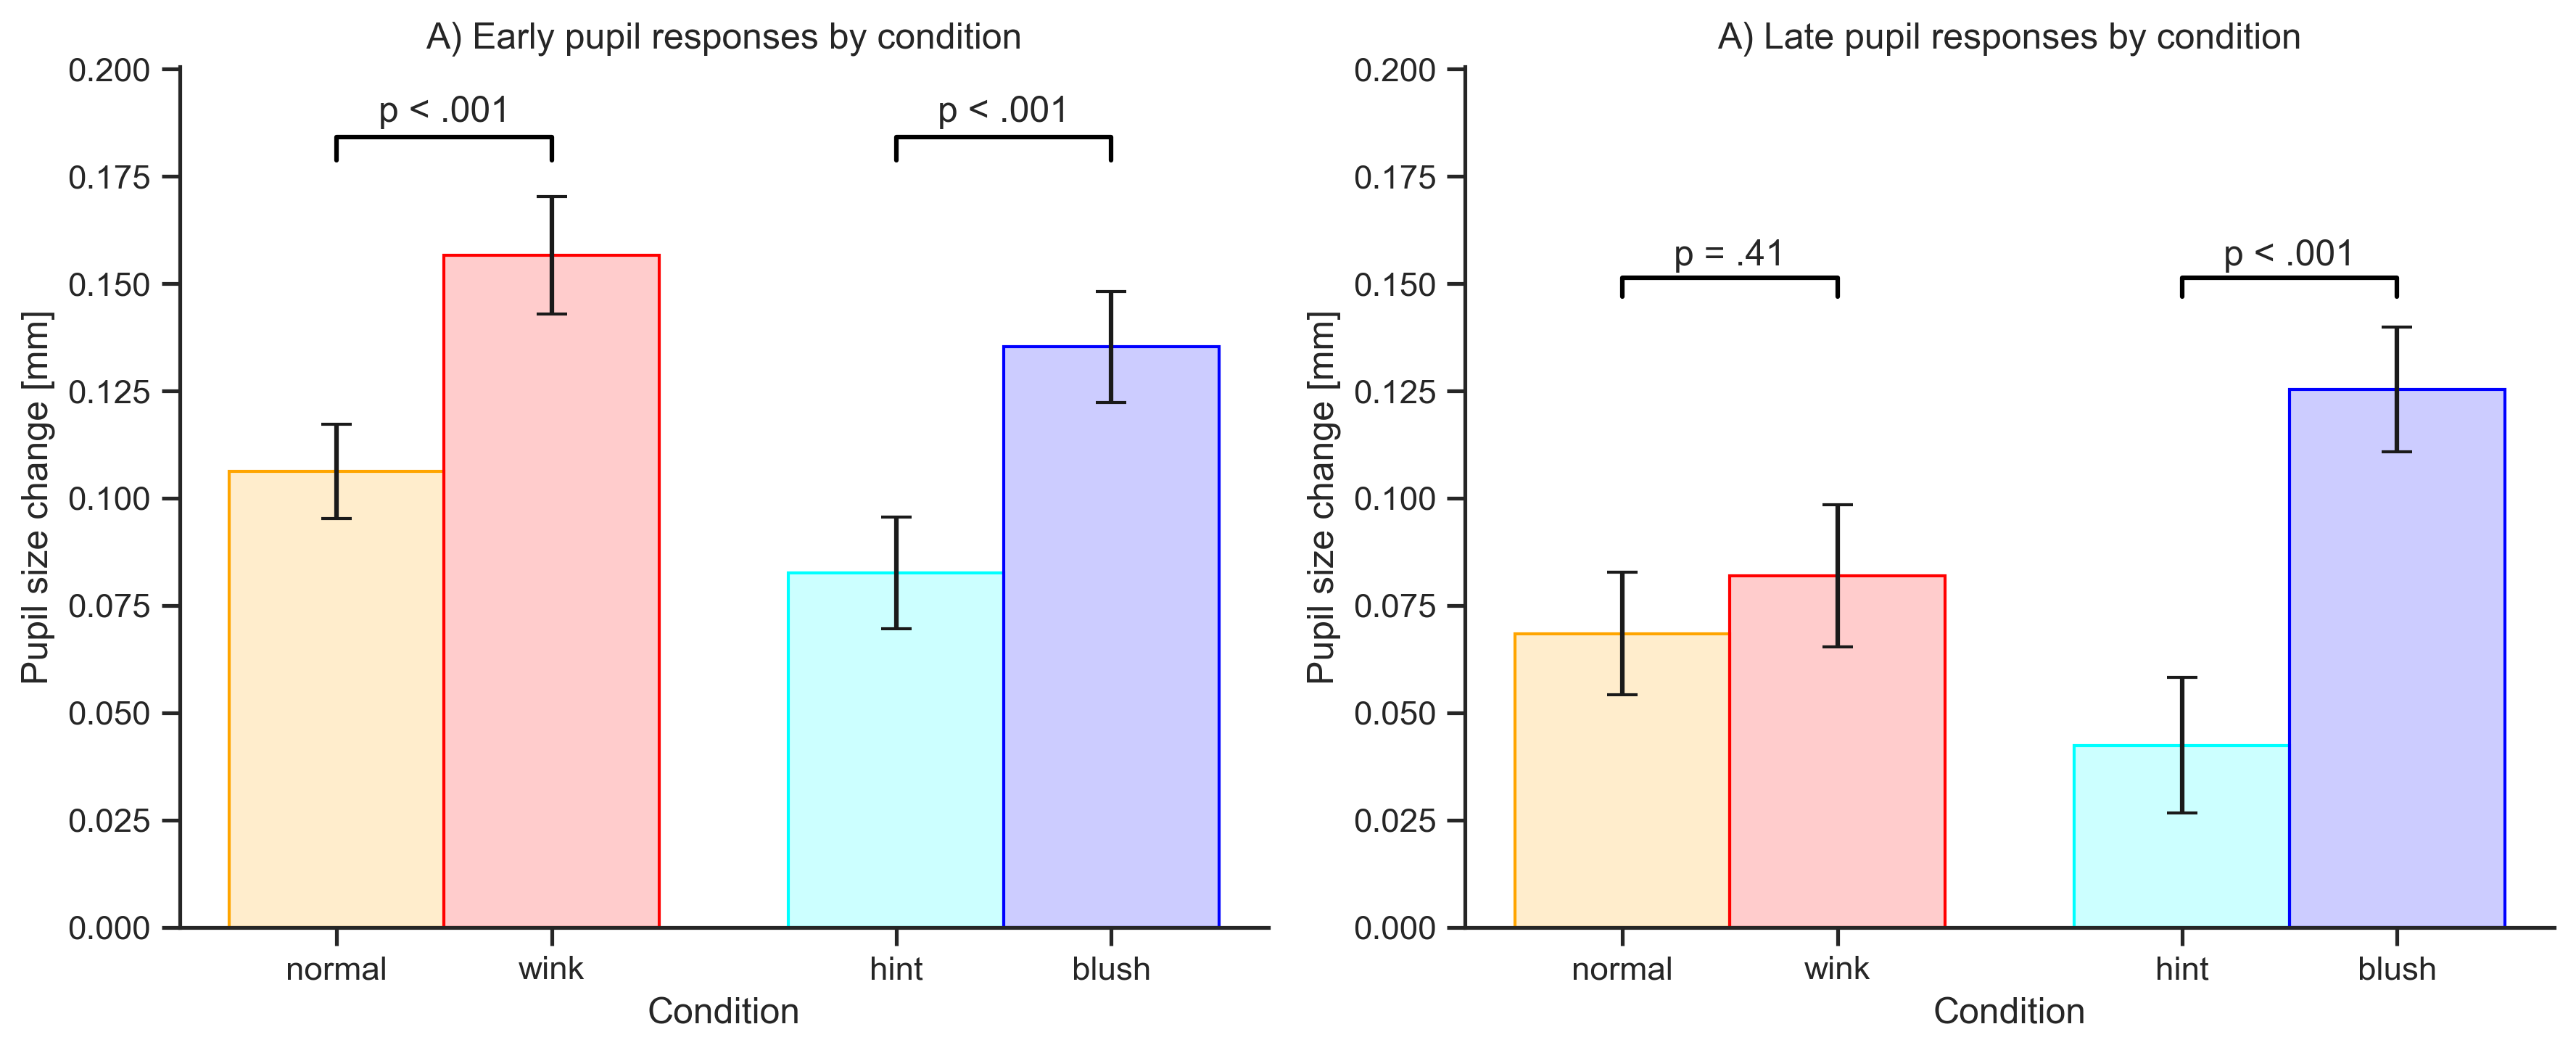

In [15]:
barCharts(data.query('~excSubject'), saveAs='figure5')

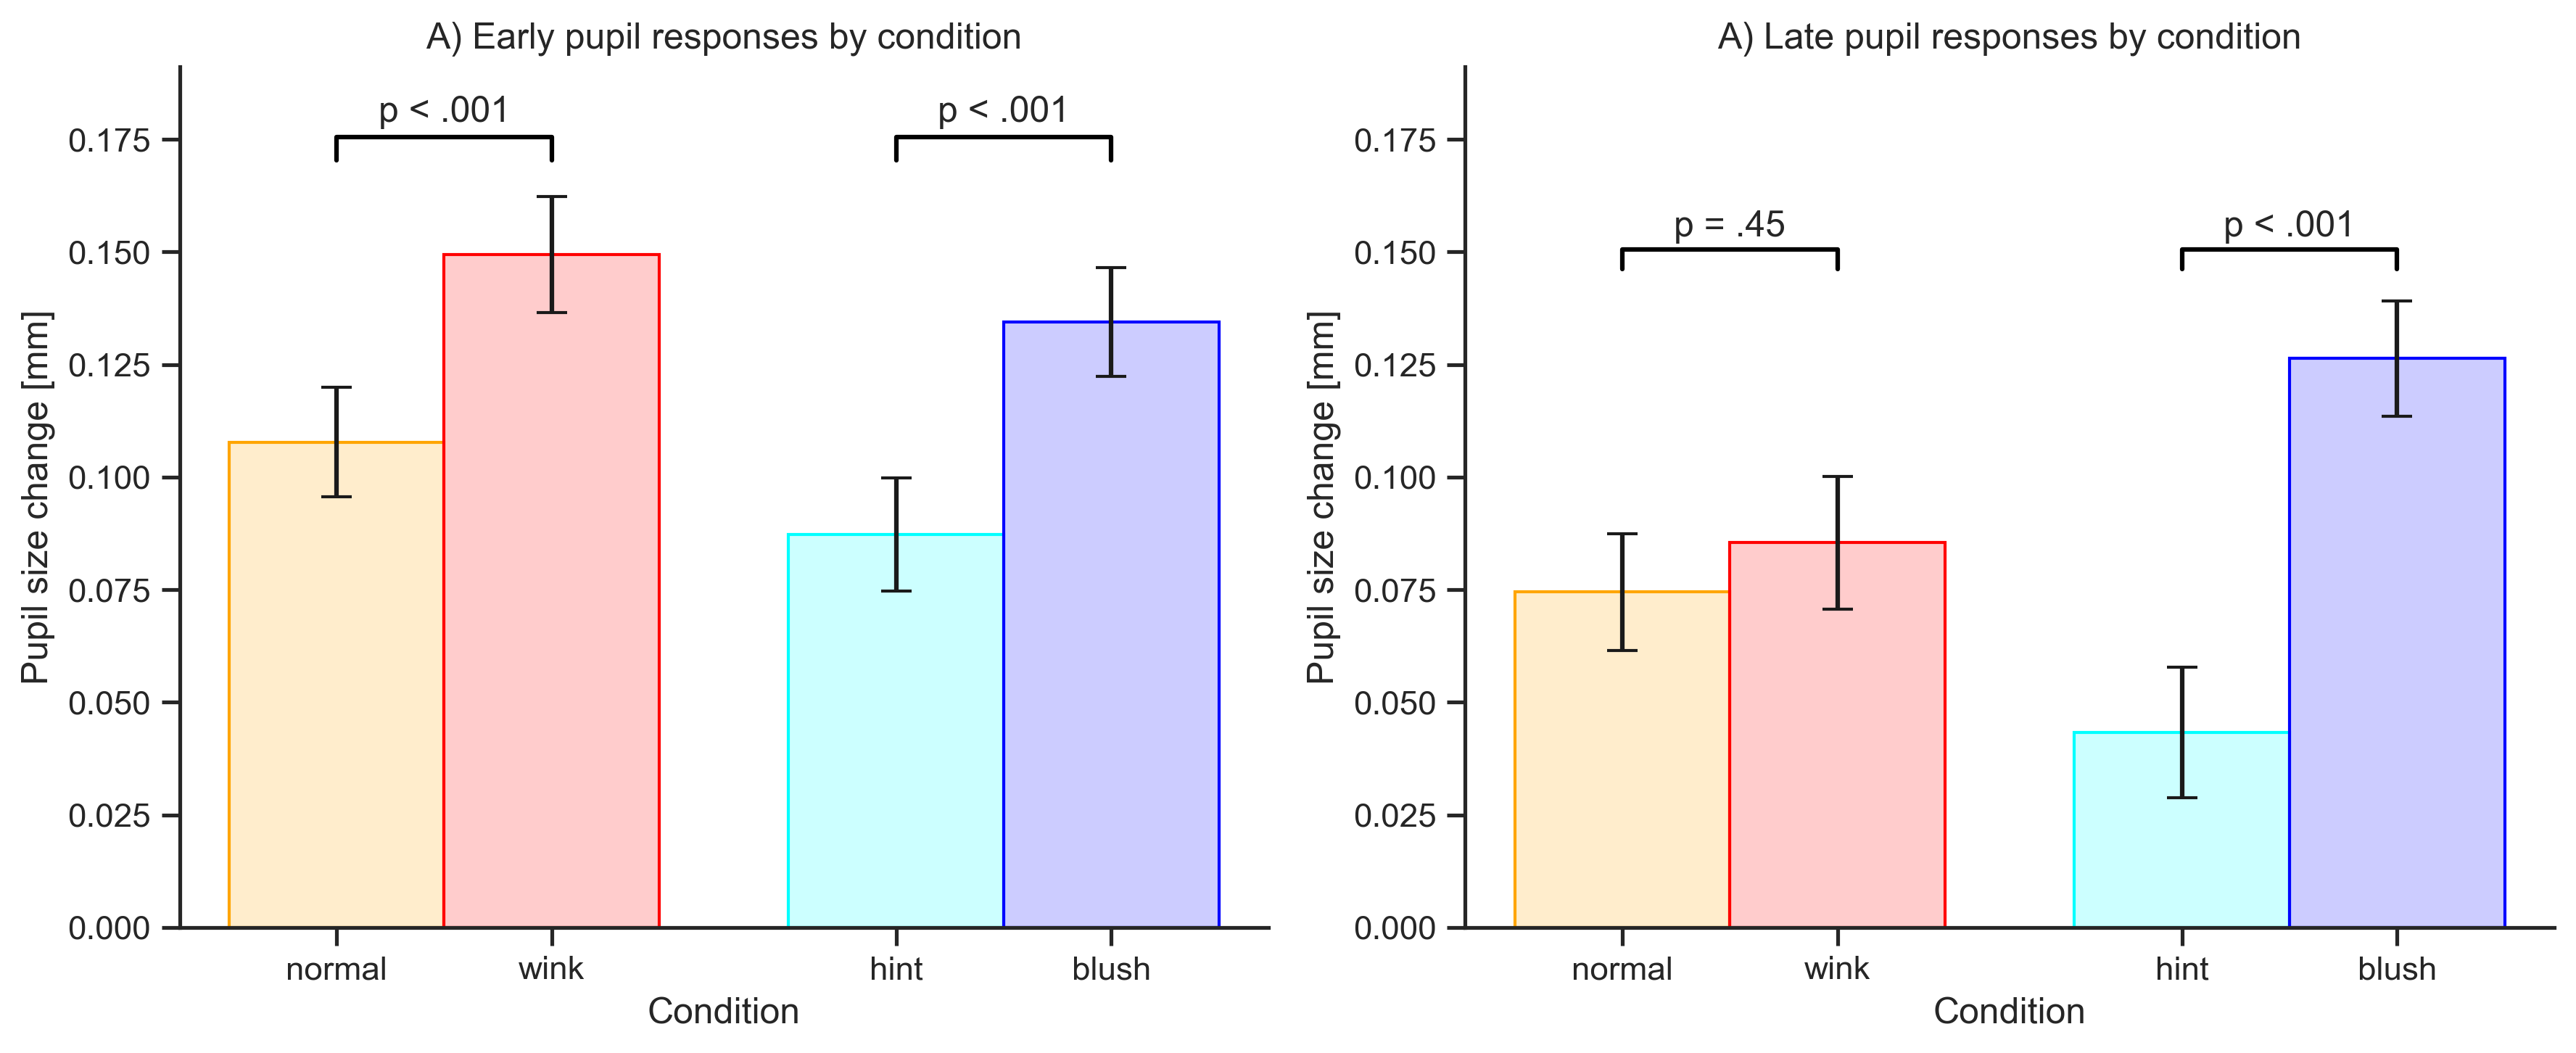

In [16]:
barCharts(data)

In [17]:
def modelsAndPlot(data, saveAs=None):
    fig = plt.figure(figsize=(12, 5), dpi=300)
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)

    print('**** Early pupil response models ****')
    earlyModels = createModels('earlyPupil', data)
    print(compareModels(earlyModels, ax=ax1))
    ax1.set_title('A) Bayesian weights of models explaining early pupil responses')
    
    print('**** Late pupil response models ****')
    lateModels = createModels('latePupil', data)
    print(compareModels(lateModels, ax=ax2))
    ax2.set_title('B) Bayesian weights of models explaining late pupil responses')
    
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42
    if saveAs is not None:
        fig.savefig(os.path.join(output_dir, f'{saveAs}.png'))
        fig.savefig(os.path.join(output_dir, f'{saveAs}.pdf'))
    plt.show()

**** Early pupil response models ****
null->kld: Chi2Result(df=1, statistic=17.385983293106392, pvalue=3.050674280333379e-05)
null->entropy: Chi2Result(df=1, statistic=18.614153443386613, pvalue=1.6002804875842357e-05)
kld->kldEntropy: Chi2Result(df=1, statistic=16.922613703250022, pvalue=3.89349747500495e-05)
entropy->kldEntropy: Chi2Result(df=1, statistic=15.694443552969801, pvalue=7.444253755271952e-05)
kldEntropy->condType: Chi2Result(df=1, statistic=0.007658161176095746, pvalue=0.930265405569447), B=16.062891484265723
        model  relativeBIC  bayesWeight
0        null    23.187234     0.000009
1         kld    11.361932     0.003181
2     entropy    10.133762     0.005879
3  kldEntropy     0.000000     0.932856
4    condType     5.553023     0.058075
**** Late pupil response models ****
null->kld: Chi2Result(df=1, statistic=0.2450099770670704, pvalue=0.6206108322824669), B=14.265382910673711
null->entropy: Chi2Result(df=1, statistic=18.33097056358531, pvalue=1.8566419845222652e

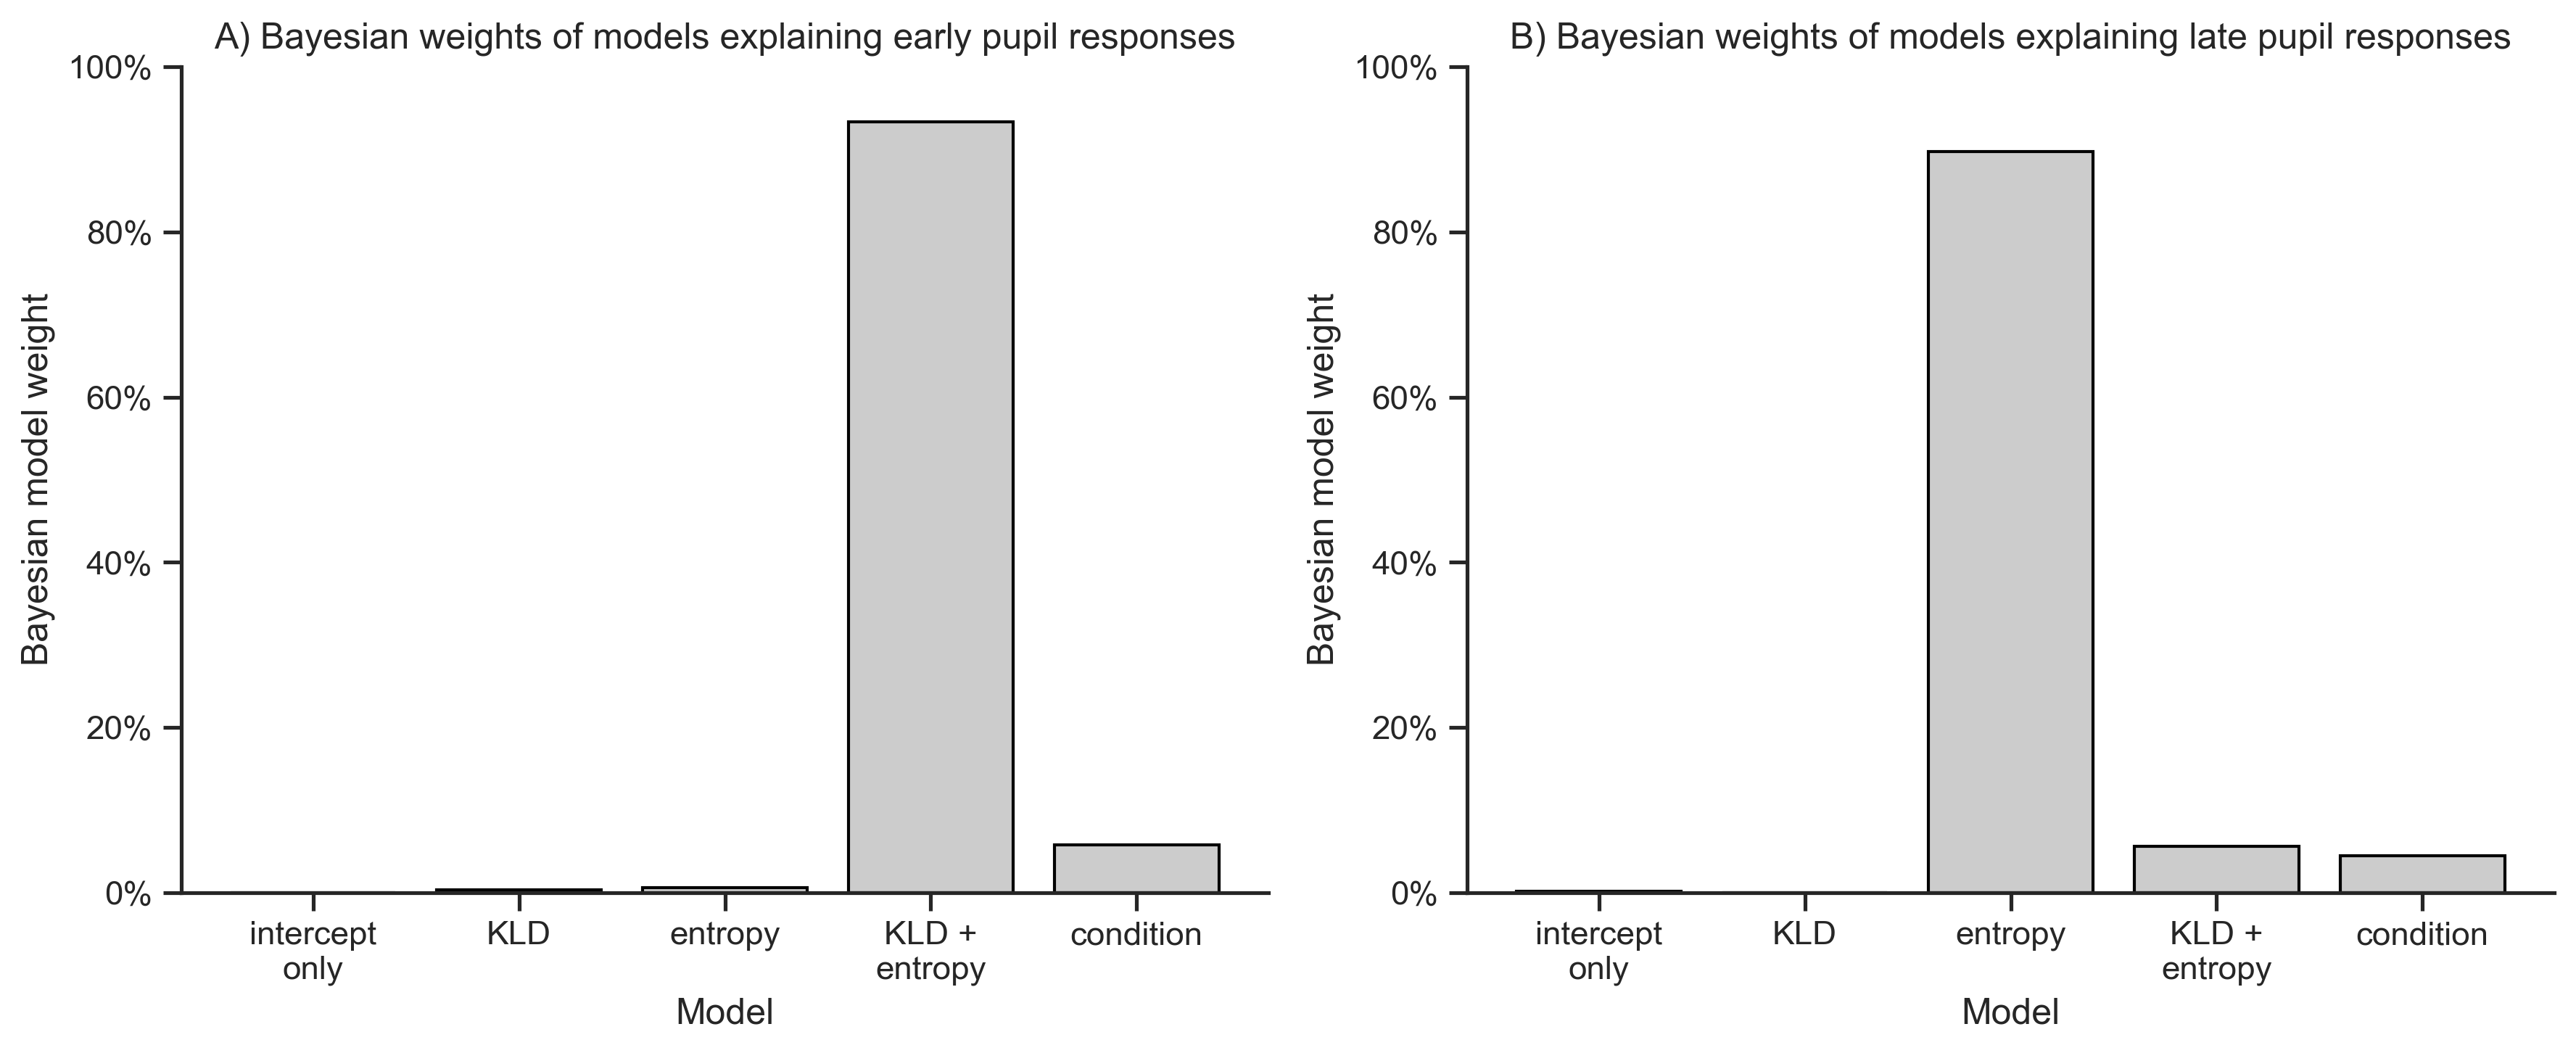

In [18]:
modelsAndPlot(data.query('~excSubject'), saveAs='figure6')

**** Early pupil response models ****
null->kld: Chi2Result(df=1, statistic=13.958096726869258, pvalue=0.0001869308171444537)
null->entropy: Chi2Result(df=1, statistic=17.192809758958674, pvalue=3.377121550115231e-05)
kld->kldEntropy: Chi2Result(df=1, statistic=15.370557422105662, pvalue=8.835434476201927e-05)
entropy->kldEntropy: Chi2Result(df=1, statistic=12.135844390016246, pvalue=0.0004946186833208972)
kldEntropy->condType: Chi2Result(df=1, statistic=0.06420778175379382, pvalue=0.7999648881165764), B=17.214761042413937
        model  relativeBIC  bayesWeight
0        null    17.817170     0.000122
1         kld     9.614815     0.007376
2     entropy     6.380102     0.037171
3  kldEntropy     0.000000     0.902883
4    condType     5.691534     0.052448
**** Late pupil response models ****
null->kld: Chi2Result(df=1, statistic=0.2635058716959975, pvalue=0.6077217400237966), B=15.582027565155776
null->entropy: Chi2Result(df=1, statistic=24.283849255212772, pvalue=8.313320471460556e

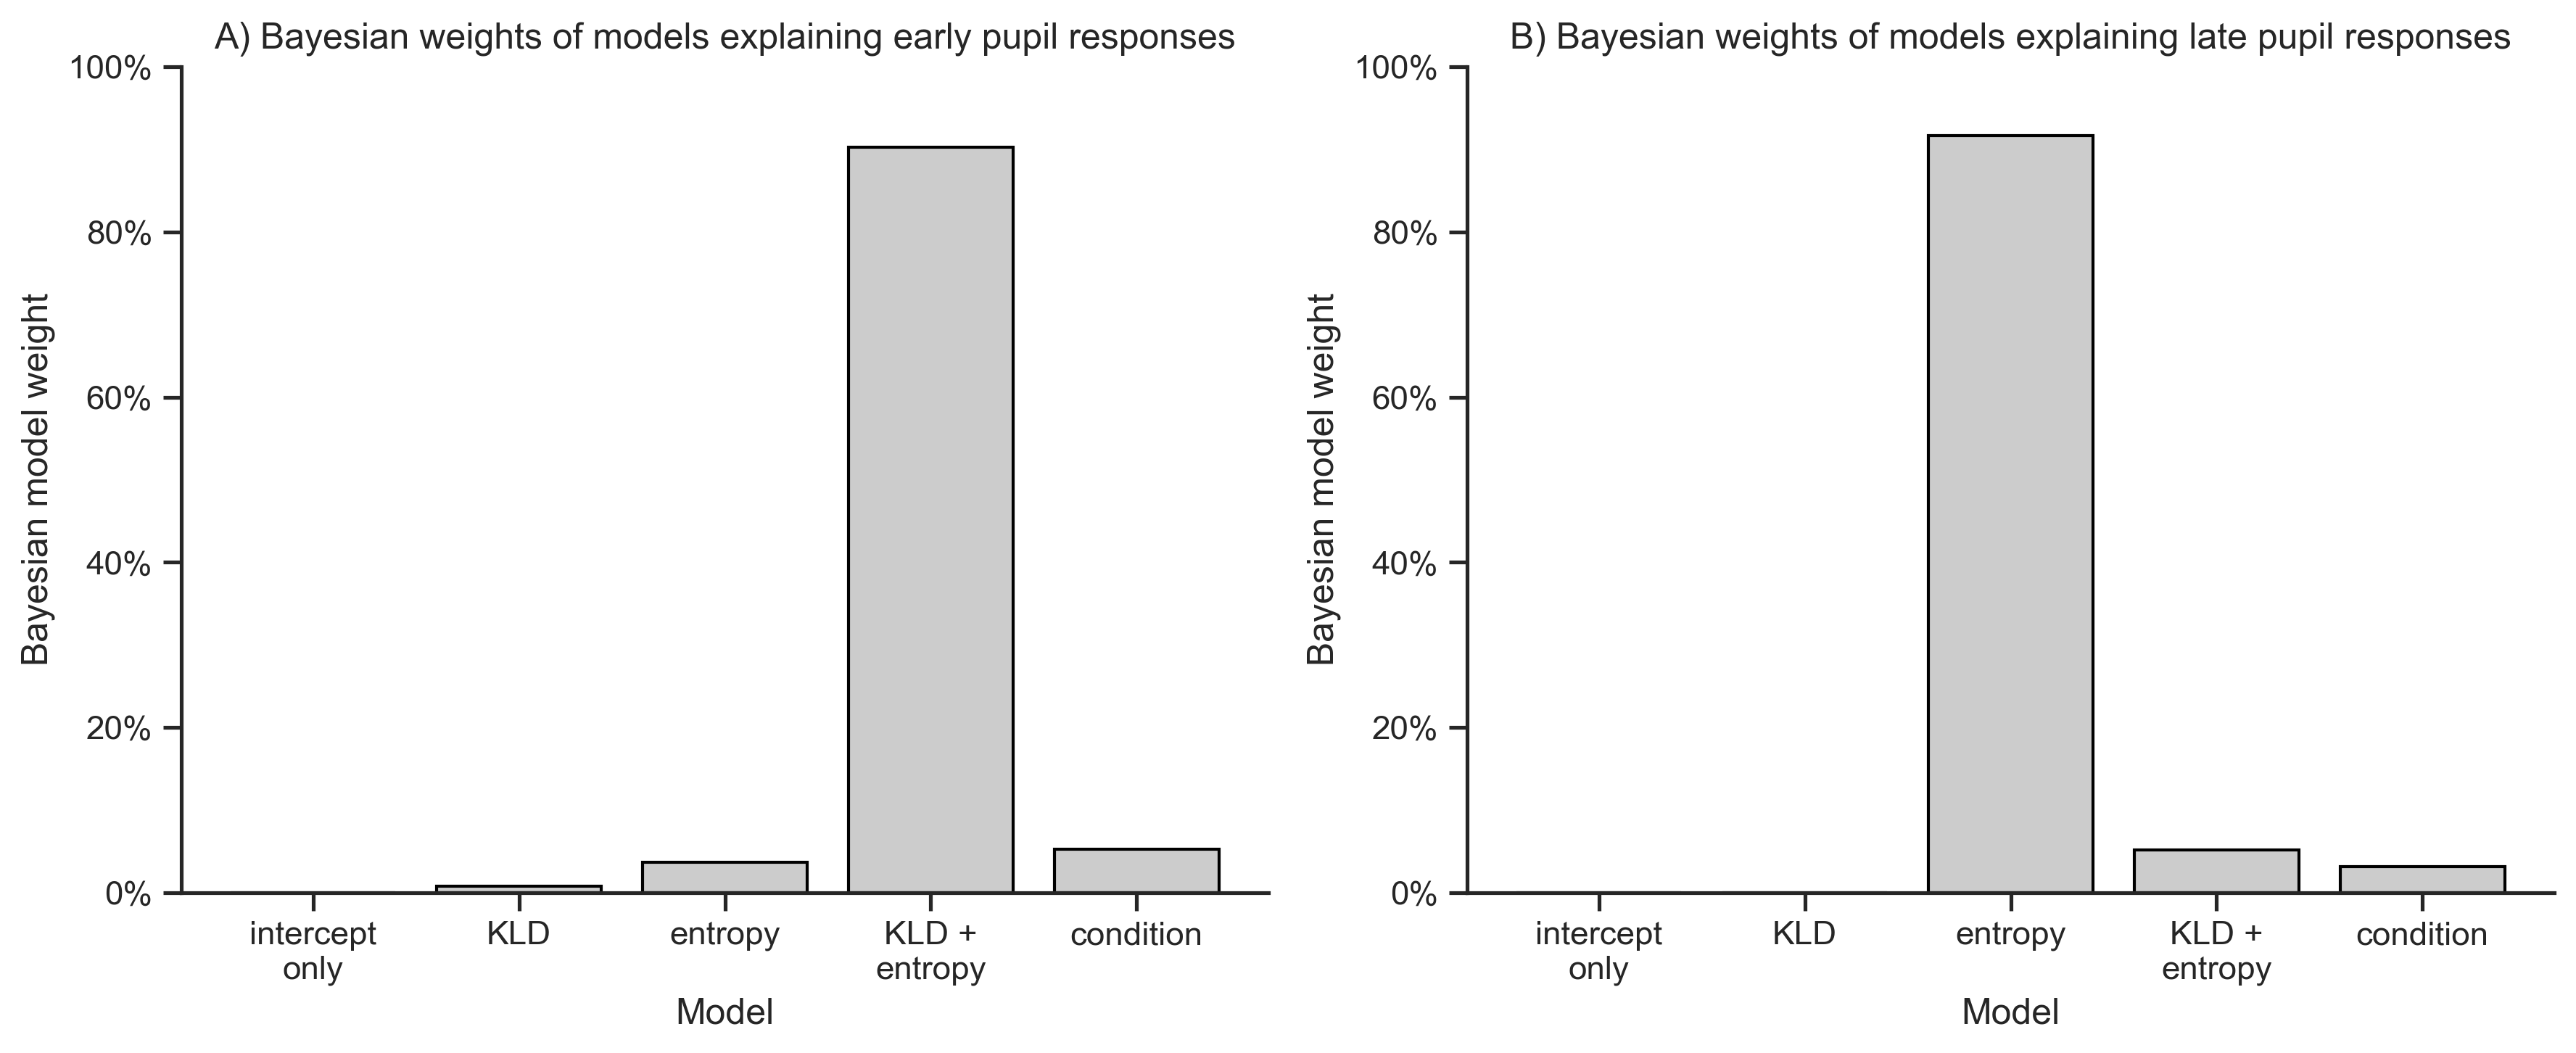

In [19]:
modelsAndPlot(data)